In [1]:
## Task discription: Get elevation of specific locations from Digital Elevation Model data.

# Two DEM data: 
#     ASTER GDEM v2.0 (ASTGDEM-v2.0)
#     Download Link: https://earthexplorer.usgs.gov/
#     EU DEM v1.1 (EUDEM-v1.1)
#     Download Link: https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1

# Terms and Abbreviations:
#     EPSG     -  European Petroleum Survey Group
#     GCS      -  Geographic Coordinate System
#     PCS      -  Projected Coordinate System
#     WGS-84   -  1984 World Geodetic System [GCS]
#     OSGB-36  -  1936 Ordnance Survey Great Britain [GCS]
#     ETRS-89  -  1989 European Terrestrial Reference System [GCS]
#     BNG      -  British National Grid [PCS of OSGB-36]

# Functions: 
#     For ASTGDEM-v2.0: 
#         1. Remove overlapped elements of ASTGDEM-v2.0 data in WGS-84 GCS.
#         2. Merge reformed ASTGDEM-v2.0 data in WGS-84 GCS.
#         3. Transform ASTGDEM-v2.0 data from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277].
#         4. Project ASTGDEM-v2.0 data from WGS-84 GCS to Web Mercator PCS [EPSG-3857].
#         4. Project ASTGDEM-v2.0 data from OSGB-36 GCS to BNG PCS [EPSG-27700].
#         5. Display ASTGDEM-v2.0 data in PCSs as 2D images (x2).
#         6. Get elevation of air quality stations from ASTGDEM-v2.0 data in WGS-84 GCS.
#         6. Get elevation of air quality stations from ASTGDEM-v2.0 data in OSGB-36 GCS.
#     For EUDEM-v1.1: 
#         1. Re-Project EUDEM-v1.1 data from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 [EPSG-4258].
#         2. Get elevation of air quality stations from EUDEM-v1.1 data in ETRS-89 GCS.

# **************************** Strongly Recommended for Tyro ****************************
# In case you do not have to read README and docs of DEM data, 
# I would like to tell you something very important when you work on DEM: 
#     - RTFM and go back to STAR this repository. XD
#     - After you download a new DEM (.tif format), use GDAL.GetProjection() to check the CS of DEM (GCS or PCS).
#     - Meanwhile, use GDAL.GetGeoTransform() to get map resolution, location of map corner (top-left).
#     - You can directly transform DEM data between different GCSs (e.g., WGS-84<->OSGB-36<->ETRS-89).
#     - You can not display DEM in GCS as 2D image (e.g., imshow(DEMinGCS) is wrong).
#     - Each GCS has a related PCS, project DEM in GCS to the related PCS and then display DEM in PCS as 2D images.
#     - You can not project DEM in GCS to other GCS related PCS (e.g., WGS-84->BNG is wrong).
#     - Good luck and have fun! XD



In [2]:
import os, sys
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import re
from pandas import read_csv
import math



In [3]:
def get_FileName(file_path, file_type):
    files = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
    
    file_names = []
    for i in files:
        if file_type in i:
            file_names.append(i)
    
    return file_names


def get_TifInfo(dem_data, tag_print):
    dem_row = dem_data.RasterYSize  # Height.
    dem_col = dem_data.RasterXSize  # Width.
    dem_band = dem_data.RasterCount
    dem_geotran = dem_data.GetGeoTransform()
    dem_proj = dem_data.GetProjection()
    
    if tag_print == 1:
        print('===> The number of rows of DEM array is: %d (height).' % dem_row)
        print('===> The number of cols of DEM array is: %d (width).' % dem_col)
        print('===> The number of bands of DEM array is: %d.' % dem_band)
        print('===> The 6 GeoTransform parameters of DEM data is:')
        print(dem_geotran)
        print('===> The projection information of DEM data is:')
        print(dem_proj)
    
    return dem_row, dem_col, dem_band, dem_geotran, dem_proj


def write_TIF(dem_array, dem_row, dem_col, dem_band, dem_geotran, dem_proj, path):
    data_type = gdal.GDT_UInt16
    
    if len(dem_array.shape) == 3:
        dem_bands, dem_row, dem_col = dem_array.shape
    elif len(dem_array.shape) == 2:
        dem_array = np.array([dem_array])
    else:
        dem_bands, (dem_row, dem_col) = 1, dem_array.shape  # Important.
    
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, dem_col, dem_row, dem_band, data_type)  # Order.
    if(dataset!= None):
        dataset.SetGeoTransform(dem_geotran)
        dataset.SetProjection(dem_proj)
    for i in range(dem_band):
        dataset.GetRasterBand(i+1).WriteArray(dem_array[i])
    del dataset
    
    return 0


def show_ProjDEM(file_path, file_name, img_path, img_name):
    gdal_data = gdal.Open(file_path + file_name)

    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan
    print('*==> The shape of the DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    print('>>>> Plot DEM image.')
    fig = plt.figure(figsize=(5, 10))
    plt.title('2D Image of ' + img_name)
    plt.imshow(gdal_array)
    plt.show()
    
    save_path = img_path
    if os.path.exists(save_path) == False:
            os.mkdir(save_path)
    fig.savefig(save_path + img_name + '.png')
    
    return 0


def get_Elevation(gcs_data, site_latlog):
    gt = gcs_data.GetGeoTransform()
    print(gt)
    print('\n')
    
    gcs_array = gcs_data.ReadAsArray().astype(np.float)
    gcs_band = gcs_data.GetRasterBand(1)
    nodataval = gcs_band.GetNoDataValue()
    if np.any(gcs_array == nodataval):
        gcs_array[gcs_array == nodataval] = np.nan
    
    M = site_latlog.shape[0]
    Xgeo = site_latlog[:, 1]  # longitude.
    Ygeo = site_latlog[:, 0]  # latitude.
    
    ele = np.zeros((M, 6))  # The elevation of M locations.
    for i in range(M):
        # Note:
        # Xgeo = GT[0] + Xpixel*GT[1] + Yline*GT[2]
        # Ygeo = GT[3] + Xpixel*GT[4] + Yline*GT[5]
        #
        # Xpixel = Pixel/column of DEM image
        # Yline  = Line/row of DEM image
        #
        # Xgeo = Longitude
        # Ygeo = Latitude
        #
        # [0] = Longitude of left-top piexl
        # [3] = Latitude of left-top pixel
        #
        # [1] = + Pixel width
        # [5] = - Pixel height
        #
        # [2] = 0 for north up image
        # [4] = 0 for north up image
        
        Xpixel = int(round((Xgeo[i] - gt[0])/gt[1]))
        Yline  = int(round((Ygeo[i] - gt[3])/gt[5]))
        
        ele[i, 0] = int(i)
        ele[i, 1] = Ygeo[i]
        ele[i, 2] = Xgeo[i]
        ele[i, 3] = Yline
        ele[i, 4] = Xpixel
        ele[i, 5] = gcs_array[Yline, Xpixel]  # The elevation of i-th location.
    
    return ele



In [4]:
file_type = ".tif"

path_astgdem_source = "DATA/DATA_ASTGDEMv20/EPSG4326_s/"
path_astgdem_reform = "DATA/DATA_ASTGDEMv20/EPSG4326_r/"
path_astgdem = "DATA/DATA_ASTGDEMv20/"

path_eudem_source = "DATA/DATA_EUDEMv11/EPSG3035_s/"
path_eudem = "DATA/DATA_EUDEMv11/"


In [5]:
### <ASTGDEM-v2.0> Remove overlapped elements of ASTGDEM-v2.0 data in WGS-84 GCS.

file_names = get_FileName(path_astgdem_source, file_type)
file_names.sort(reverse=True)  # W -> E.
for i, name in enumerate(file_names):
    print('\n>>> Process the %d-th DEM file: %s.' % (i+1, name))
    
    gdal_data = gdal.Open(path_astgdem_source + name)
    tag = 1  # Do print info.
    row, col, band, geotran, proj = get_TifInfo(gdal_data, tag)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    print('*==> The shape of DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan
    
    gdal_array = np.delete(gdal_array, -1, axis=0)  # Delete Last/Bottom Row.
    gdal_array = np.delete(gdal_array, -1, axis=1)  # Delete Last/Right Col.
    print('*==> The shape of reformed DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    path = path_astgdem_reform
    if os.path.exists(path) == False:
        os.mkdir(path)
    tmp_path = path + name
    print('\n>>> Write reformed DEM data to TIF file.')
    write_TIF(gdal_array, gdal_array.shape[0], gdal_array.shape[1], band, geotran, proj, tmp_path)

print('\n>>> Complete!\n')



>>> Process the 1-th DEM file: ASTGTM2_N51W001_dem.tif.
===> The number of rows of DEM array is: 3601 (height).
===> The number of cols of DEM array is: 3601 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM data is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
*==> The shape of DEM array is: [3601, 3601].
*==> The shape of reformed DEM array is: [3600, 3600].

>>> Write reformed DEM data to TIF file.

>>> Process the 2-th DEM file: ASTGTM2_N51E000_dem.tif.
===> The number of rows of DEM array is: 3601 (height).
===> The number of cols of DEM array is: 3601 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform para

In [6]:
### <ASTGDEM-v2.0> Merge reformed ASTGDEM-v2.0 data in WGS-84 GCS.

dem_out = "ASTGDEMv20_EPSG4326.tif"

file_names = get_FileName(path_astgdem_reform, file_type)
file_names.sort(reverse=True)  # W -> E.
dem_merged_array = []
for i, name in enumerate(file_names):
    if "ASTGTM2" in name:  # Select ASTGTM2_***.tif files.
        print('\n>>> Process the %d-th DEM file: %s.' % (i+1, name))

        gdal_data = gdal.Open(path_astgdem_reform + name)
        gdal_array = gdal_data.ReadAsArray().astype(np.float)
        print('*==> The shape of DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

        gdal_band = gdal_data.GetRasterBand(1)
        nodataval = gdal_band.GetNoDataValue()
        if np.any(gdal_array == nodataval):
            gdal_array[gdal_array == nodataval] = np.nan

        # Merge DEM arrays.
        tmp = re.findall(r'-?\d+\.?\d*', name)
        tmp_Lat = tmp[1]
        tmp_Log = tmp[2]
        if tmp_Lat == '51':  # not perfect
            if tmp_Log == '001':
                dem_merged_array = gdal_array
            else:
                dem_merged_array = np.concatenate((dem_merged_array, gdal_array), axis=1)

print('\n*==> The shape of merged DEM array is: [%d, %d].' % (dem_merged_array.shape[0], dem_merged_array.shape[1]))

# Set the correct GeoTransform parameters (from the left-top DEM file)!!!
gdal_data = gdal.Open(path_astgdem_reform + file_names[0])  # the left-top DEM file.
tag = 0  # Not print info.
row, col, band, geotran, proj = get_TifInfo(gdal_data, tag)

path = path_astgdem
if os.path.exists(path) == False:
    os.mkdir(path)
tmp_path = path + dem_out
print('\n>>> Write merged DEM data to ' + dem_out)
write_TIF(dem_merged_array, dem_merged_array.shape[0], dem_merged_array.shape[1], band, geotran, proj, tmp_path)

print('\n>>> Complete!\n')



>>> Process the 1-th DEM file: ASTGTM2_N51W001_dem.tif.
*==> The shape of DEM array is: [3600, 3600].

>>> Process the 2-th DEM file: ASTGTM2_N51E000_dem.tif.
*==> The shape of DEM array is: [3600, 3600].

*==> The shape of merged DEM array is: [3600, 7200].

>>> Write merged DEM data to ASTGDEMv20_EPSG4326.tif

>>> Complete!



In [7]:
### <ASTGDEM-v2.0> Transform ASTGDEM-v2.0 data from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277].

print('\n>>> Transform ASTGDEM-v2.0 data from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277].')

path = path_astgdem
dem_in  = path + "ASTGDEMv20_EPSG4326.tif"
dem_out = path + "ASTGDEMv20_EPSG4277.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4277" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Transform ASTGDEM-v2.0 data from WGS-84 GCS [EPSG-4326] to OSGB-36 GCS [EPSG-4277].

>>> Complete!



In [8]:
### <ASTGDEM-v2.0> Project ASTGDEM-v2.0 data from WGS-84 GCS to Web Mercator PCS [EPSG-3857].

print('\n>>> Project ASTGDEM-v2.0 data from WGS-84 GCS to Web Mercator PCS [EPSG-3857].')

path = path_astgdem
dem_in  = path + "ASTGDEMv20_EPSG4326.tif"
dem_out = path + "ASTGDEMv20_EPSG3857.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project ASTGDEM-v2.0 data from WGS-84 GCS to Web Mercator PCS [EPSG-3857].

>>> Complete!



In [9]:
### <ASTGDEM-v2.0> Project ASTGDEM-v2.0 data from OSGB-36 GCS to BNG PCS [EPSG-27700].

print('\n>>> Project ASTGDEM-v2.0 data from OSGB-36 GCS to BNG PCS [EPSG-27700].')

path = path_astgdem
dem_in  = path + "ASTGDEMv20_EPSG4277.tif"
dem_out = path + "ASTGDEMv20_EPSG27700.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4277 -t_srs EPSG:27700" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project ASTGDEM-v2.0 data from OSGB-36 GCS to BNG PCS [EPSG-27700].

>>> Complete!



*==> The shape of the DEM array is: [5041, 6276].
>>>> Plot DEM image.


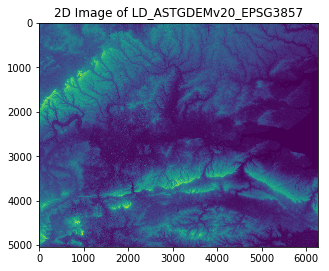

===> The number of rows of DEM array is: 5041 (height).
===> The number of cols of DEM array is: 6276 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-111334.95183366034, 35.47497364189955, 0.0, 6800150.567328675, 0.0, -35.47497364189955)
===> The projection information of DEM data is:
PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"],AUTHORITY["EPSG","3857"]]


*==> The shape of the DEM array is: [5203, 6418].
>>>> P

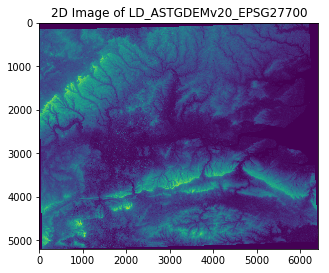

===> The number of rows of DEM array is: 5203 (height).
===> The number of cols of DEM array is: 6418 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(468736.14475350257, 22.101898961294147, 0.0, 237774.34151860897, 0.0, -22.101898961294147)
===> The projection information of DEM data is:
PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","27700"]]




In [10]:
### <ASTGDEM-v2.0> Display ASTGDEM-v2.0 data in PCSs as 2D images (x2).

img_path = "IMG/"
path = path_astgdem

# DEM in Web Mercator PCS.
dem_name = "ASTGDEMv20_EPSG3857.tif"
img_name = "LD_ASTGDEMv20_EPSG3857"
show_ProjDEM(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_TifInfo(data, 1)
print('\n')

# DEM in BNG PCS.
dem_name = "ASTGDEMv20_EPSG27700.tif"
img_name = "LD_ASTGDEMv20_EPSG27700"
show_ProjDEM(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_TifInfo(data, 1)
print('\n')


In [11]:
### <EUDEM-v1.1> Read EUDEM-v1.1 data (about 1 minute, not needed).

file_names = get_FileName(path_eudem_source, file_type)
# file_names.sort(reverse=True)  # W -> E.
for i, name in enumerate(file_names):
    print('\n>>> Process the %d-th DEM file: %s.' % (i+1, name))
    
    gdal_data = gdal.Open(path_eudem_source + name)
    tag = 1  # Do print info.
    row, col, band, geotran, proj = get_TifInfo(gdal_data, tag)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    print('*==> The shape of DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan

print('\n>>> Complete!\n')



>>> Process the 1-th DEM file: eu_dem_v11_E30N30.tif.
===> The number of rows of DEM array is: 40000 (height).
===> The number of cols of DEM array is: 40000 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(3000000.0, 25.0, 0.0, 4000000.0, 0.0, -25.0)
===> The projection information of DEM data is:
PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
*==> The shape of DEM array is: [40000, 40000].

>>> Complete!



In [12]:
### <EUDEM-v1.1> Re-Project EUDEM-v1.1 data from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 [EPSG-4258] (about 3 minutes).

print('\n>>> Re-Project EUDEM-v1.1 data from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 [EPSG-4258].')

path = path_eudem
dem_in  = path + "EUDEMv11_EPSG3035.tif"
dem_out = path + "EUDEMv11_EPSG4258.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:3035 -t_srs EPSG:4258" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Re-Project EUDEM-v1.1 data from ETRS-LAEA PCS [EPSG-3035] to ETRS-89 [EPSG-4258].

>>> Complete!



In [13]:
# It takes a long time to display the whole image of one EUDEM-v1.1 data file.


In [14]:
### Read London air quality station data.

site_path = "DATA/DATA_LD_AirQuality/London_AirQuality_Stations.csv"
site_data_raw = read_csv(site_path)  # Station data (pandas.DF).
print(site_data_raw.head(3))
print('\n')

site_num = site_data_raw['SiteName'].count()  # The number of stations.
print(site_num)
print('\n')


  Unnamed: 0 api_data need_prediction  historical_data   Latitude  Longitude  \
0        BX9     True             NaN             True  51.465983   0.184877   
1        BX1     True             NaN             True  51.465983   0.184877   
2        BL0     True            True             True  51.522287  -0.125848   

           SiteType                   SiteName  
0          Suburban  Bexley - Slade Green FDMS  
1          Suburban       Bexley - Slade Green  
2  Urban Background        Camden - Bloomsbury  


24




In [15]:
### Read latitude and longitude of stations.

site_latlog = np.zeros((site_num, 2))  # The latitude and longitude of stations.
site_latlog[:, 0] = site_data_raw['Latitude']  # 0-th col - lat!
site_latlog[:, 1] = site_data_raw['Longitude']  # 1-th col - long!

np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_latlog)
print('\n')


[[51.46598327  0.18487713]
 [51.46598327  0.18487713]
 [51.522287   -0.125848  ]
 [51.52770662 -0.12905321]
 [51.544219   -0.175284  ]
 [51.51452534 -0.10451563]
 [51.51384718 -0.07776568]
 [51.410039   -0.127523  ]
 [51.490532    0.074003  ]
 [51.45258     0.070766  ]
 [51.486957    0.095111  ]
 [51.456357    0.040725  ]
 [51.4563      0.085606  ]
 [51.617327   -0.298775  ]
 [51.52078746  0.20546071]
 [51.48878    -0.441627  ]
 [51.52104675 -0.21349214]
 [51.52104675 -0.21349214]
 [51.474954   -0.039641  ]
 [51.56948433  0.08290747]
 [51.42525604 -0.34560829]
 [51.3892869  -0.14166153]
 [51.51504617 -0.00841849]
 [51.52254    -0.15459   ]]




In [16]:
gcs_path_astgdem = "DATA/DATA_ASTGDEMv20/"
gcs_wgs  = "ASTGDEMv20_EPSG4326.tif"
gcs_osgb = "ASTGDEMv20_EPSG4277.tif"

gcs_path_eudem = "DATA/DATA_EUDEMv11/"
gcs_etrs = "EUDEMv11_EPSG4258.tif"


In [17]:
### <ASTGDEM-v2.0> Get elevation of air quality stations from ASTGDEM-v2.0 data in WGS-84 GCS.

gcs_data = gdal.Open(gcs_path_astgdem + gcs_wgs)

tag = 1
get_TifInfo(gcs_data, tag)

# Get elevation.
site_ele_wgs = get_Elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_ele_wgs)
print('\n')
print(site_ele_wgs[:, 5].astype(int))
print('\n')


===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM data is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)


[[   0.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   1.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   2.           51.522287     -0.125848   1720.         3147.
    38.        ]
 [   3.           51.52770662   -0.12905321 1701.         3136.
    40.        ]
 [   4.           

In [18]:
### <ASTGDEM-v2.0> Get elevation of air quality stations from ASTGDEM-v2.0 data in OSGB-36 GCS.

gcs_data = gdal.Open(gcs_path_astgdem + gcs_osgb)

tag = 1
get_TifInfo(gcs_data, tag)

# Get elevation.
site_ele_osgb = get_Elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_ele_osgb)
print('\n')
print(site_ele_osgb[:, 5].astype(int))
print('\n')


===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
===> The projection information of DEM data is:
GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)


[[   0.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   1.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   2.           51.522287     -0.125848   1719.         3142.
    36.        ]
 [   3.           51

In [19]:
### <EUDEM-v1.1> Get elevation of air quality stations from EUDEM-v1.1 data in ETRS-89 GCS (about 1 minute).

gcs_data = gdal.Open(gcs_path_eudem + gcs_etrs)

tag = 1
get_TifInfo(gcs_data, tag)

# Get elevation.
site_ele_etrs = get_Elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_ele_etrs)
print('\n')
print(site_ele_etrs[:, 5].astype(int))
print('\n')


===> The number of rows of DEM array is: 30505 (height).
===> The number of cols of DEM array is: 52428 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-12.266271034206424, 0.00033920980218715875, 0.0, 58.98761768429964, 0.0, -0.00033920980218715875)
===> The projection information of DEM data is:
GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]]
(-12.266271034206424, 0.00033920980218715875, 0.0, 58.98761768429964, 0.0, -0.00033920980218715875)


[[    0.            51.46598327     0.18487713 22174.
  36706.            12.63551998]
 [    1.            51.46598327     0.18487713 22174.
  36706.            12.63551998]
 [    2.            51.522287      -0.125848   22008.
  35790.            37.60099411]
 [    3.  

In [20]:
print(site_ele_wgs[:, 5].astype(int))
print('\n')
print(site_ele_osgb[:, 5].astype(int))
print('\n')
print(site_ele_etrs[:, 5].astype(int))
print('\n')


[18 18 38 40 65 26 35 31 17 79 13 41 62 82  9 13 31 31 15 22 24 40  8 40]


[14 14 36 25 60 37 33 40 20 68 12 25 62 59 15 18 22 22 15 21 14 33  8 47]


[12 12 37 30 61 25 29 36 11 66 11 31 64 79  7 27 25 25 14 15 13 32  5 36]


